## Setup, Loading Data and CDFs

In [2]:
DATA_NAME = 'ravdess-1e5geore' #dataset-compression
TRANSFORM = 'stft-normal_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [3]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
normal_intensity_stft_1e5geore_ravdess.ipynb


In [4]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geore\\stft\\normal_intensity'

In [5]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [6]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [7]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [8]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


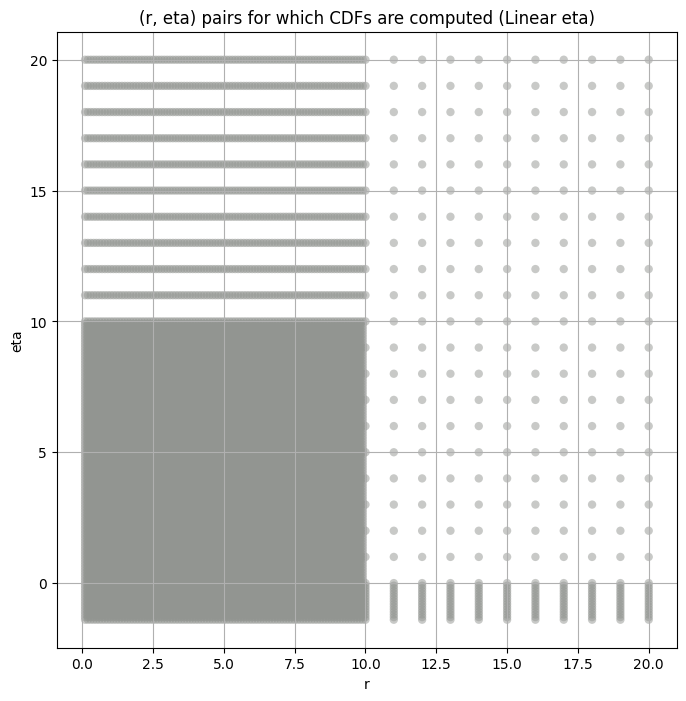

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [9]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [10]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [11]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,35.658936,30.577213,44.852737,53.40648,13.841323,225.49278,100000.0
3,24.671465,19.792730,36.469307,155.64215,23.847439,605.96010,100000.0
4,22.381815,17.656353,31.781504,135.76886,34.770958,503.89240,100000.0
5,12.393164,9.773663,16.739542,110.49154,39.733475,364.34058,100000.0
6,11.326435,8.476332,19.273914,314.24930,43.632740,1044.14140,100000.0
7,4.390030,3.317100,6.534811,184.00717,46.270640,629.45245,100000.0
8,0.972178,0.734719,1.474245,196.93523,43.928898,679.22850,100000.0
9,0.286370,0.205979,0.508150,383.67706,56.914790,1211.13300,100000.0


## Initial Grid Search and Hypothesis Test Plots

In [12]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [13]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,35.658936,35.658936,32.253990,30.925093,29.919750,29.088547,27.730183,26.620319,25.670294,24.834270,24.083818,22.198288
3,24.671465,24.671465,20.985498,19.735750,18.812063,18.066427,16.886259,15.960903,15.193764,14.536494,13.961392,12.568093
4,22.381815,22.381815,19.079895,17.751514,16.745892,15.920304,14.592918,13.533300,12.651887,11.898072,11.240292,9.665464
5,12.393164,12.393164,10.591712,9.803782,9.208167,8.718793,7.930943,7.303675,6.781271,6.333707,5.942990,5.009308
6,11.326435,11.326435,9.204694,8.476398,7.927745,7.479270,6.760023,6.190550,5.717536,5.314012,4.963608,4.134907
7,4.390030,4.390030,3.603550,3.296989,3.071432,2.889443,2.601997,2.379031,2.197049,2.043237,1.910610,1.599695
8,0.972178,0.972178,0.798407,0.733235,0.685132,0.646195,0.584276,0.535664,0.495615,0.461576,0.432071,0.362300
9,0.286370,0.286370,0.225902,0.204363,0.188311,0.175327,0.154923,0.139177,0.126428,0.115788,0.106717,0.085983


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.004142398995586216 35.658936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.006630402723539569 32.25399


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.006374174076447359 30.925093


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.005035722390375197 29.91975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.003328675526604208 29.088547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0036041074632672775 27.730183


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0048352039003601854 26.62032


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.006204814805084953 25.670294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.006386301298477393 24.83427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.006640270701624797 24.083818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.007877999256145556 22.198288
Number of samples: 100000, Without approximation : 100000.0


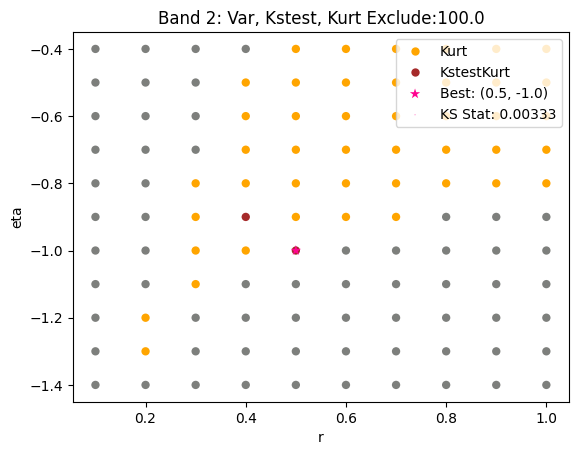

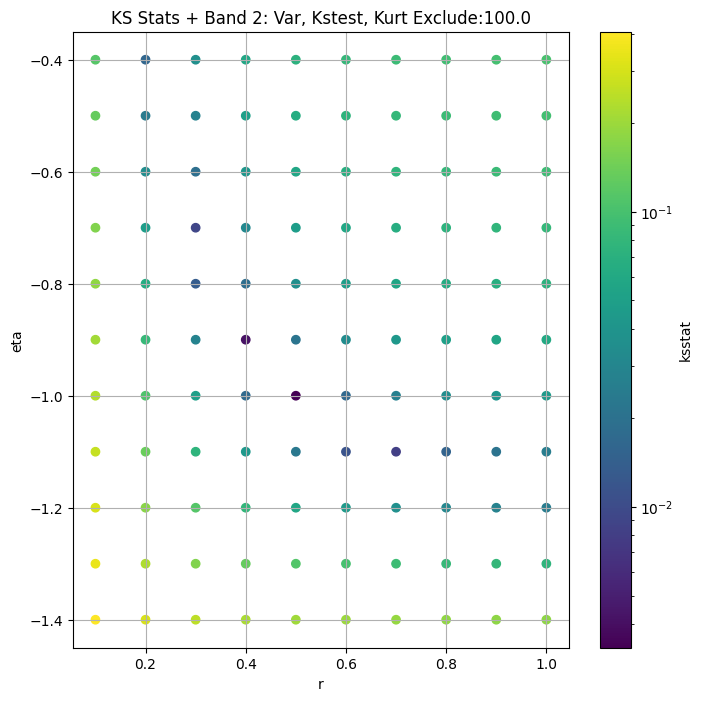

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.004967577142629631 24.671465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.01044944198106057 20.985498


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.007672196272487053 19.73575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0056539971818364565 18.812063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.003971312404888017 18.066427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.006830309753171754 16.88626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.0056048341551525604 15.960903


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.005197767241882416 15.193764


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.0066730610458173995 14.536494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.007635824701040406 13.961392


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.008033543840441044 12.568093
Number of samples: 100000, Without approximation : 100000.0


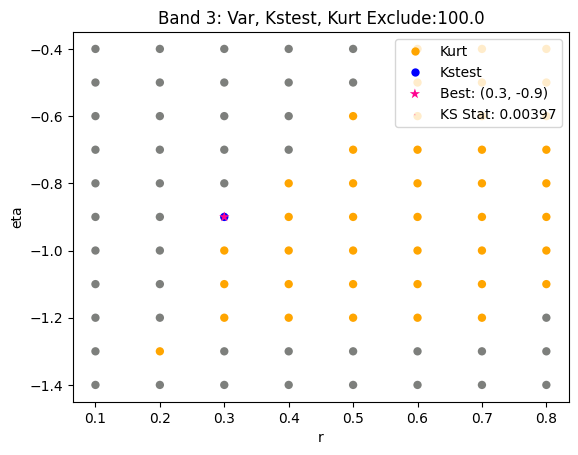

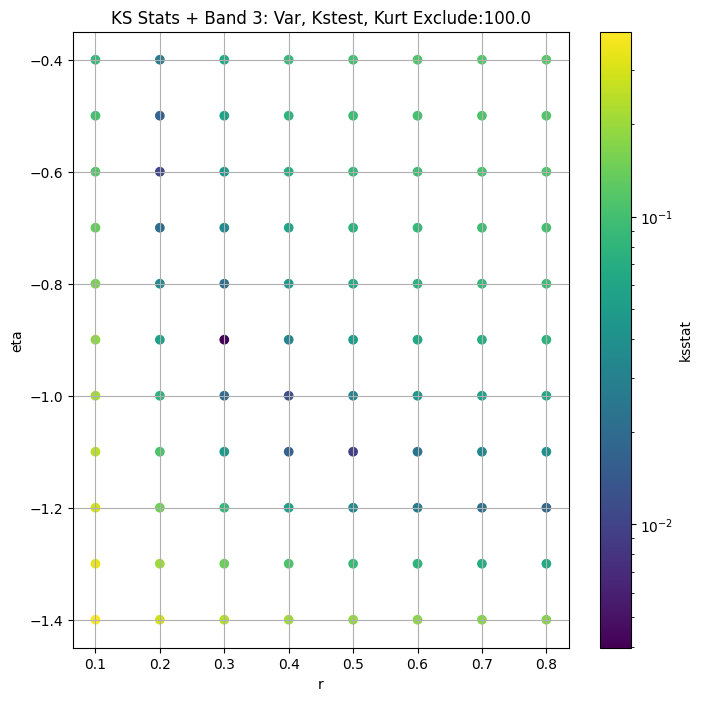

####
Band  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.0035754095841891154 22.381815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.007989210682496833 19.079895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.005815772000410391 17.751514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.00663878118034561 16.745892


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.00791386497062363 15.920304


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.008369774737867819 14.592918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.010682671832451723 13.5333


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.011029724119162254 12.651887


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.008025672741310386 11.898072


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.008667952005150883 11.240292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.009107021244767411 9.665464
Number of samples: 100000, Without approximation : 100000.0


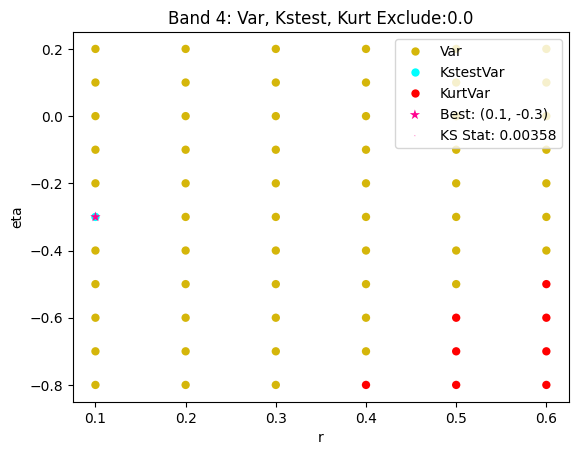

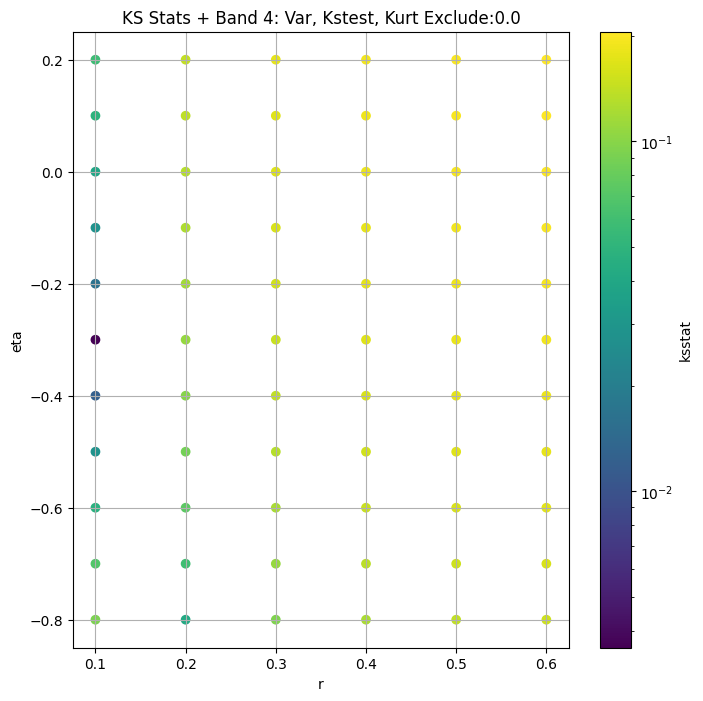

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.011061340268901931 12.393164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.013223956150292815 10.591712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.009114920767321899 9.8037815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.007640055575183602 9.208167


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.009023128106258771 8.718793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.007554660036771965 7.930943


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.00777461302462976 7.3036747


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008791874041640692 6.7812715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.009072554354127415 6.3337073


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.009988388544083817 5.9429903


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009876794519952646 5.009308
Number of samples: 100000, Without approximation : 100000.0


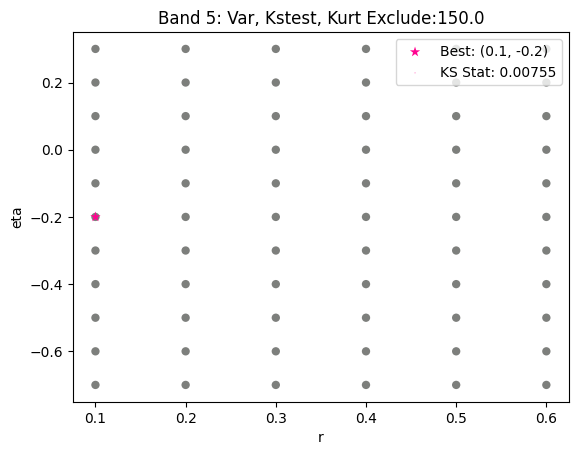

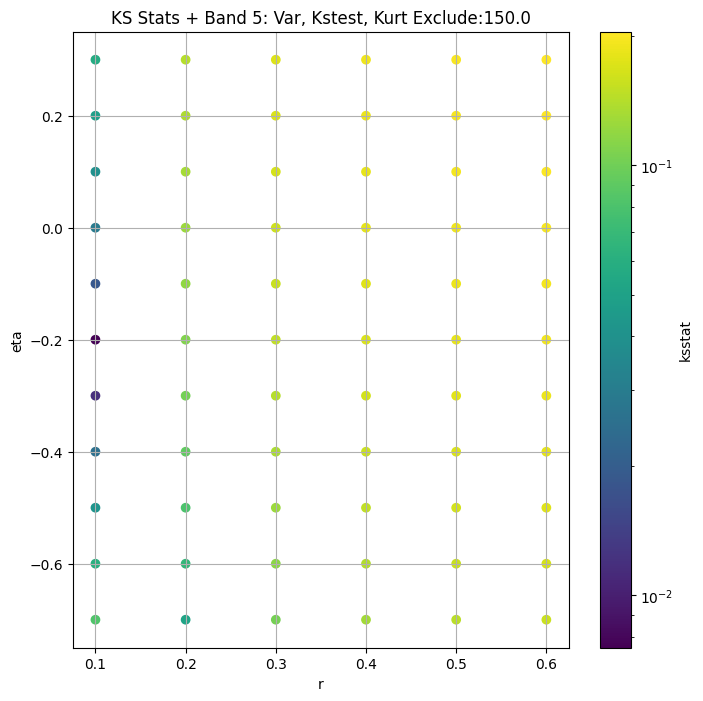

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.019512219098700156 11.326435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.015012621011865845 9.204694


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.01456708815218588 8.476398


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.01122769796912293 7.927745


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.009991520002823384 7.47927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.01151654628671106 6.7600226


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.0071224985922095155 6.1905503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.008277579247999878 5.7175364


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.008380774309139371 5.3140116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.00916888039592598 4.9636083


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.010157388526613187 4.134907
Number of samples: 100000, Without approximation : 100000.0


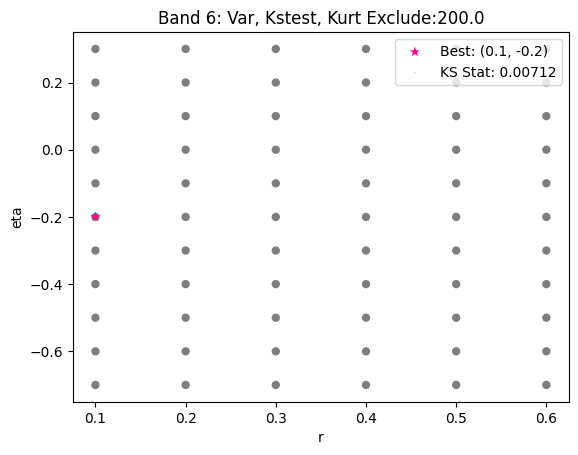

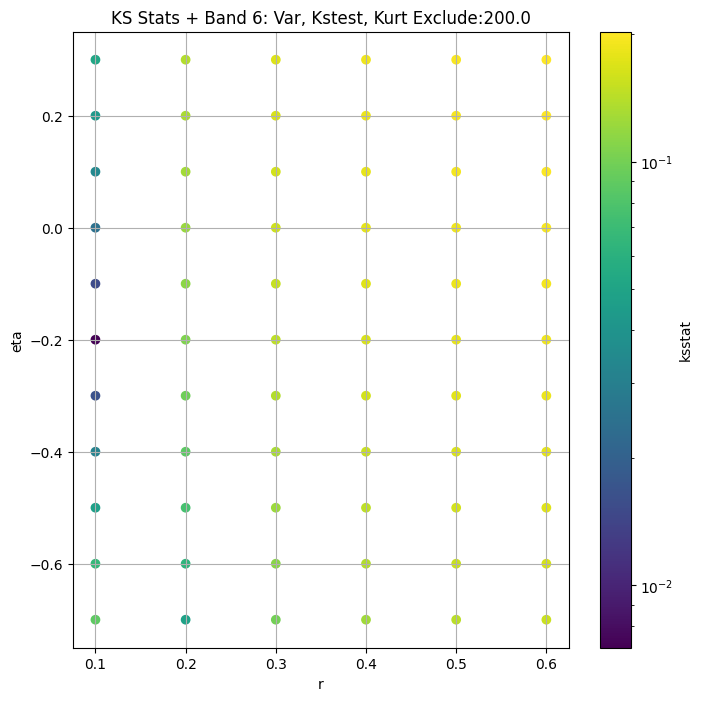

####
Band  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.018163699009643985 4.39003


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.012842001865795594 3.6035504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.015629329114868584 3.296989


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.012973682060304359 3.0714316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.009794677122047735 2.8894427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.01217170346072649 2.6019971


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.007220644331133785 2.3790312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.009293723572746104 2.1970494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.008234096253388005 2.043237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.009112946117728147 1.9106096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.010735604907076911 1.5996951
Number of samples: 100000, Without approximation : 100000.0


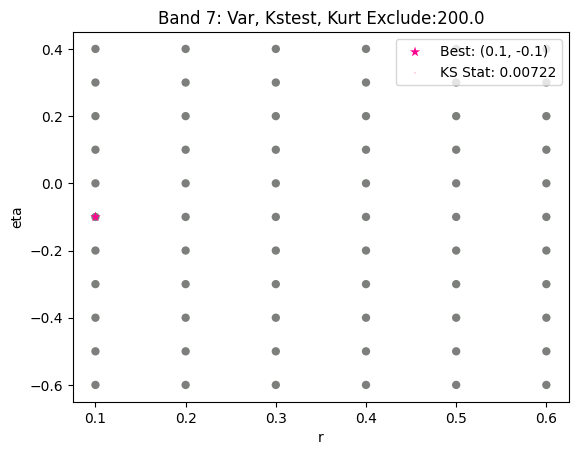

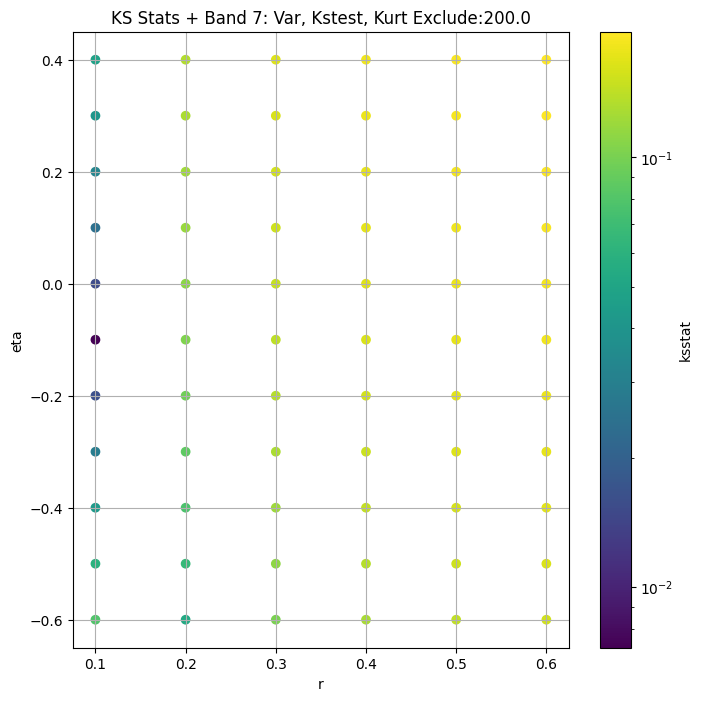

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.022770148734565843 0.97217846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.01876681909319372 0.7984072


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.01933755157316963 0.7332352


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.015644659075101486 0.6851323


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.016511666776714562 0.6461948


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.014096604755175823 0.5842758


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.014489633786999856 0.53566366


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.011511475016100697 0.49561515


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.012008509354227093 0.461576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.009904392812930957 0.43207085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010135377499580588 0.36230022
Number of samples: 100000, Without approximation : 100000.0


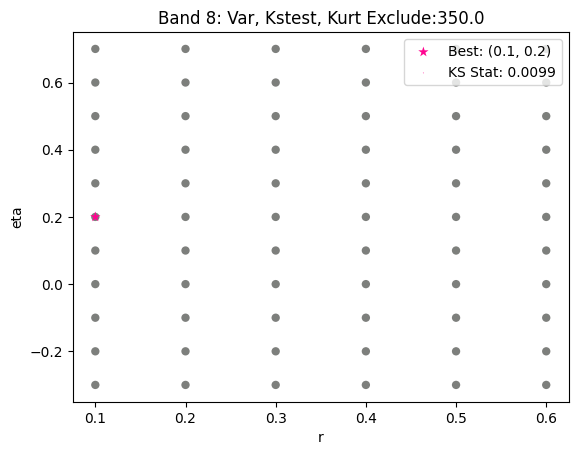

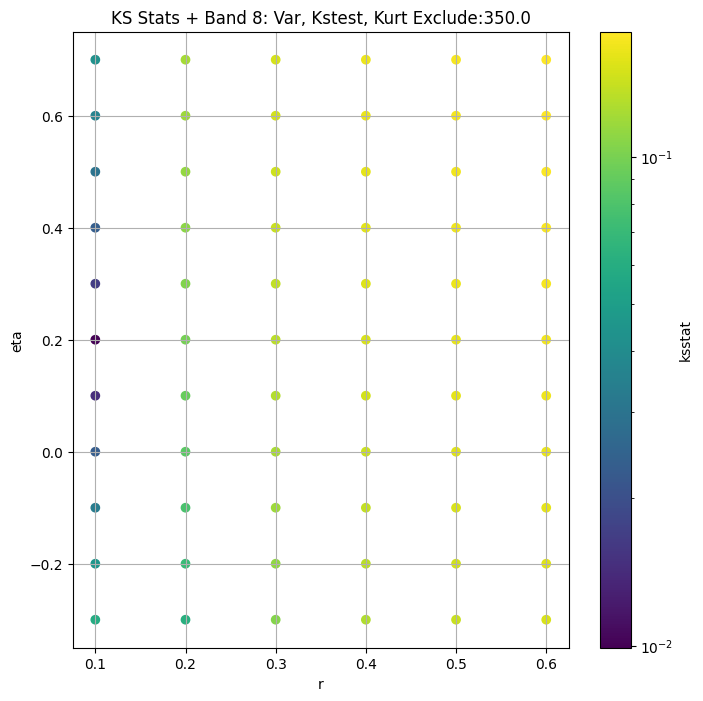

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.032048927311611464 0.28636977


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.028372821765909717 0.22590238


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.023224249086915894 0.20436268


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.024147943763905055 0.18831134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.02263310015207809 0.17532727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.02135991712115687 0.15492295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.01704596856263607 0.13917656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.01806789627821337 0.12642811


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.015211305372460127 0.11578753


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.014356972133071855 0.10671682


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.012463136896917748 0.08598314
Number of samples: 100000, Without approximation : 100000.0


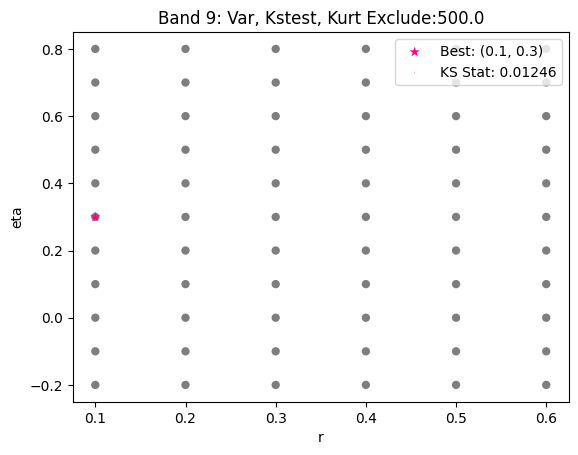

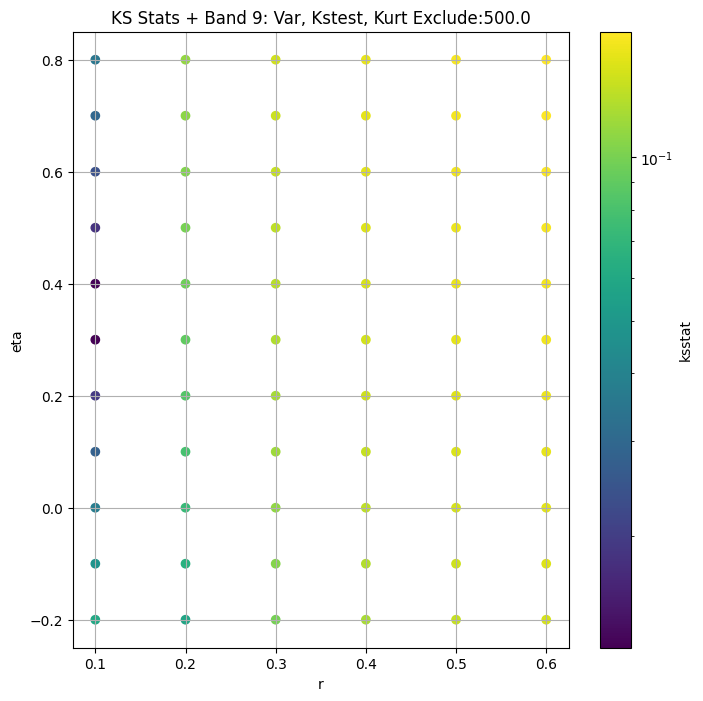

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,35.658936,30.577213,44.852737,53.40648,13.841323,225.49278,100000.0,0.003329,0.5,-1.0,1.454427e+01,100.0,29.088547,0.004293
3,24.671465,19.792730,36.469307,155.64215,23.847439,605.96010,100000.0,0.003971,0.3,-0.9,4.502093e-01,100.0,18.066427,0.004293
4,22.381815,17.656353,31.781504,135.76886,34.770958,503.89240,100000.0,0.003575,0.1,-0.3,1.748667e-11,0.0,22.381815,0.004293
5,12.393164,9.773663,16.739542,110.49154,39.733475,364.34058,100000.0,0.007555,0.1,-0.2,3.379833e-12,150.0,7.930943,0.004293
6,11.326435,8.476332,19.273914,314.24930,43.632740,1044.14140,100000.0,0.007122,0.1,-0.2,2.638151e-12,200.0,6.190550,0.004293
7,4.390030,3.317100,6.534811,184.00717,46.270640,629.45245,100000.0,0.007221,0.1,-0.1,5.730414e-13,200.0,2.379031,0.004293
8,0.972178,0.734719,1.474245,196.93523,43.928898,679.22850,100000.0,0.009904,0.1,0.2,2.241587e-14,350.0,0.432071,0.004293
9,0.286370,0.205979,0.508150,383.67706,56.914790,1211.13300,100000.0,0.012463,0.1,0.3,2.808659e-15,500.0,0.085983,0.004293


In [14]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [15]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 100 = 200, ksstat: 0.004057185331341442, var: 26.620319366455078


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 75 = 175, ksstat: 0.003627039989501441, var: 27.150888442993164


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 50 = 150, ksstat: 0.003446010888671077, var: 27.730182647705078


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 25 = 125, ksstat: 0.0030283726814132675, var: 28.370586395263672


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 0 = 100, ksstat: 0.0024877295661610045, var: 29.088546752929688


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + -25 = 75, ksstat: 0.0020618911929893846, var: 29.919750213623047


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + -50 = 50, ksstat: 0.0017826800735672305, var: 30.925092697143555


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + -75 = 25, ksstat: 0.0010941730355381596, var: 32.253990173339844


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + -100 = 0, ksstat: 0.002276531852435093, var: 35.658935546875
Number of samples: 100000, Without approximation : 100000.0


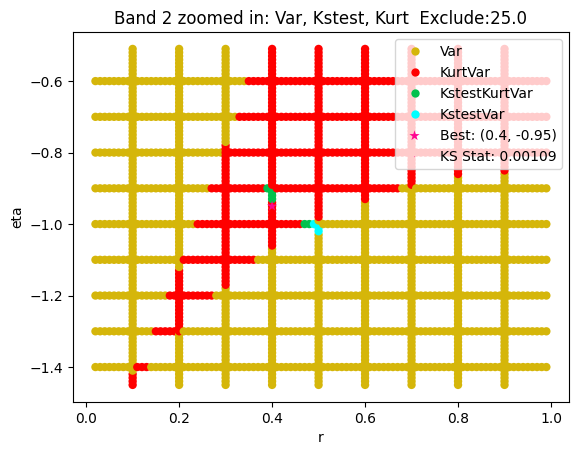

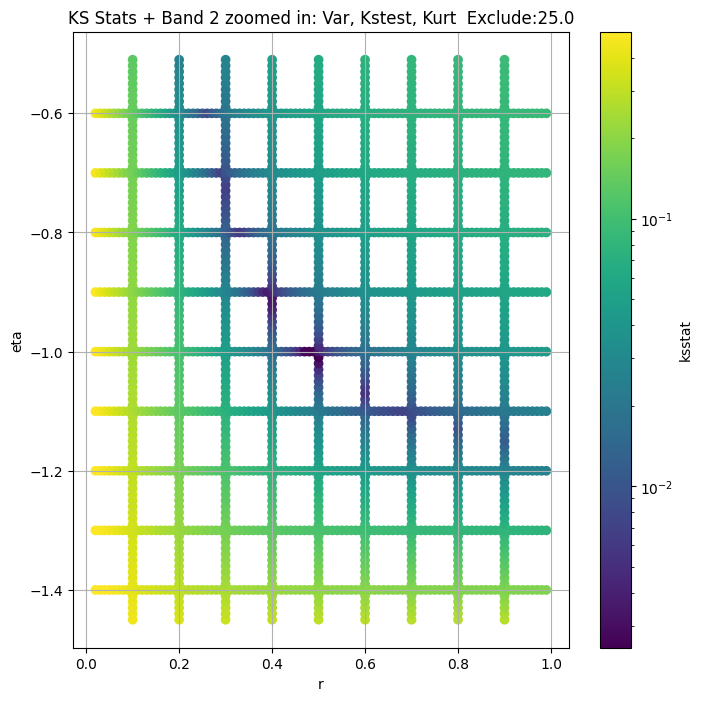

Band 3


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 100 = 200, ksstat: 0.004037836439647422, var: 15.96090316772461


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 75 = 175, ksstat: 0.0037099189543752485, var: 16.399375915527344


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 50 = 150, ksstat: 0.003457945303698584, var: 16.886259078979492


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 25 = 125, ksstat: 0.0034127304651972445, var: 17.435178756713867


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 0 = 100, ksstat: 0.0037855582995797166, var: 18.06642723083496


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + -25 = 75, ksstat: 0.002853016392717317, var: 18.812063217163086


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + -50 = 50, ksstat: 0.002208972928977093, var: 19.735750198364258


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + -75 = 25, ksstat: 0.0024178515724060934, var: 20.985498428344727


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + -100 = 0, ksstat: 0.00350959923981925, var: 24.671464920043945
Number of samples: 100000, Without approximation : 100000.0


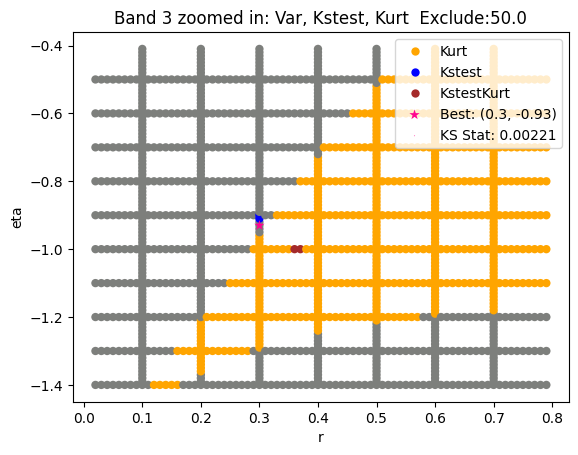

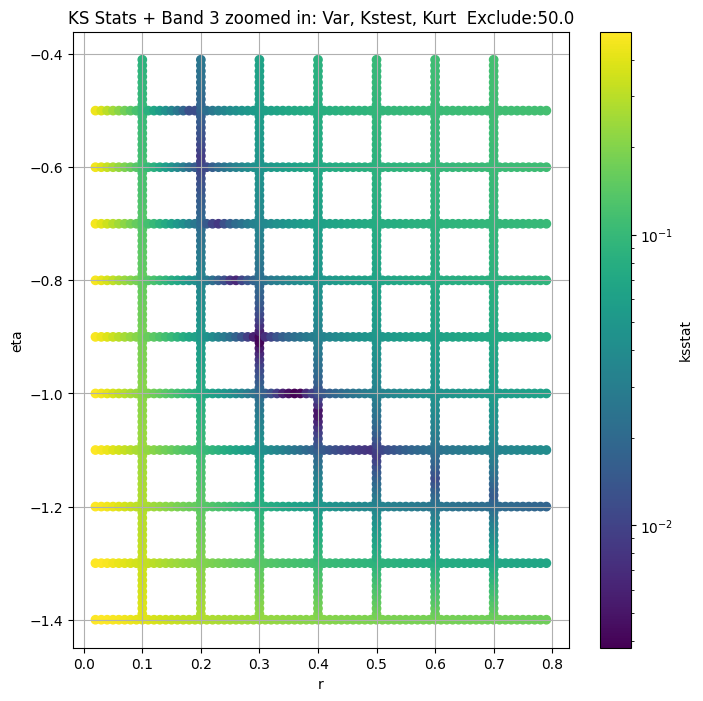

Band 4


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 100 = 100, ksstat: 0.0054861983893524265, var: 15.920304298400879


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 75 = 75, ksstat: 0.004633659074247929, var: 16.745891571044922


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 50 = 50, ksstat: 0.004731191363850973, var: 17.751514434814453


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 25 = 25, ksstat: 0.003949155788544663, var: 19.07989501953125


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 0 = 0, ksstat: 0.0026395785937591947, var: 22.38181495666504
Number of samples: 100000, Without approximation : 100000.0


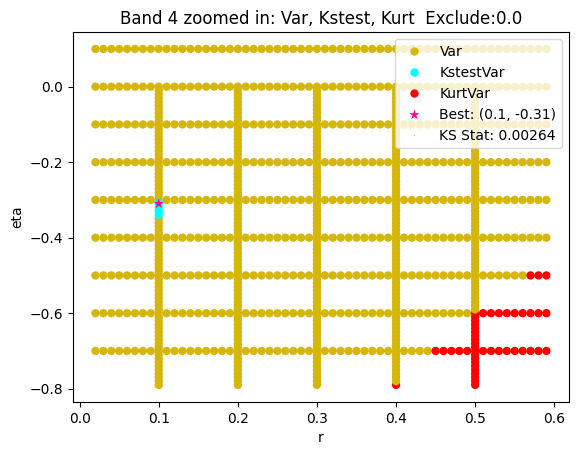

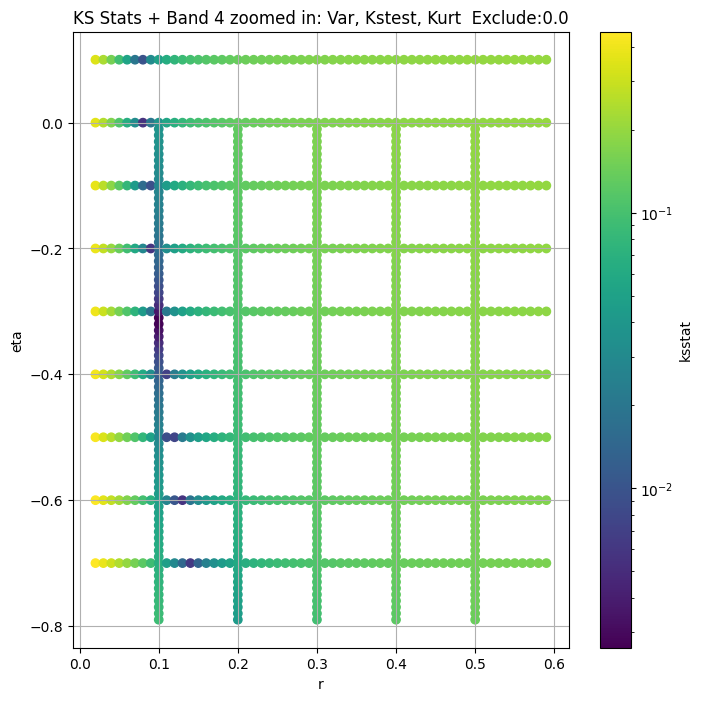

Band 5


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 100 = 250, ksstat: 0.0077601042682464445, var: 6.781271457672119


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 75 = 225, ksstat: 0.007625736452707921, var: 7.031708717346191


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 50 = 200, ksstat: 0.007492863508848369, var: 7.303674697875977


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 25 = 175, ksstat: 0.007195040052209396, var: 7.601393222808838


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 0 = 150, ksstat: 0.006779048018830079, var: 7.930943012237549


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + -25 = 125, ksstat: 0.006413654354753747, var: 8.299610137939453


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + -50 = 100, ksstat: 0.006189292956381419, var: 8.718792915344238


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + -75 = 75, ksstat: 0.006795287122245308, var: 9.20816707611084


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + -100 = 50, ksstat: 0.007693929349911588, var: 9.803781509399414
Number of samples: 100000, Without approximation : 100000.0


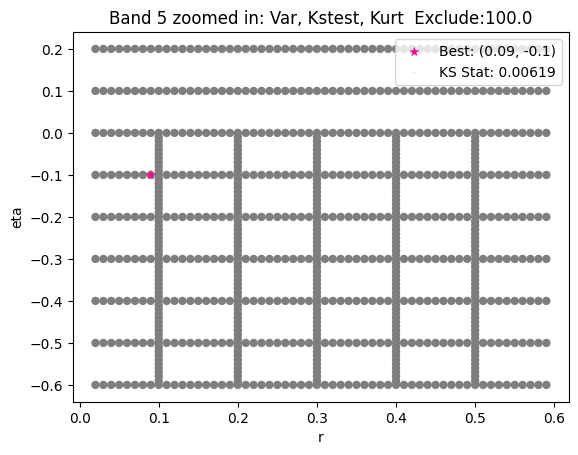

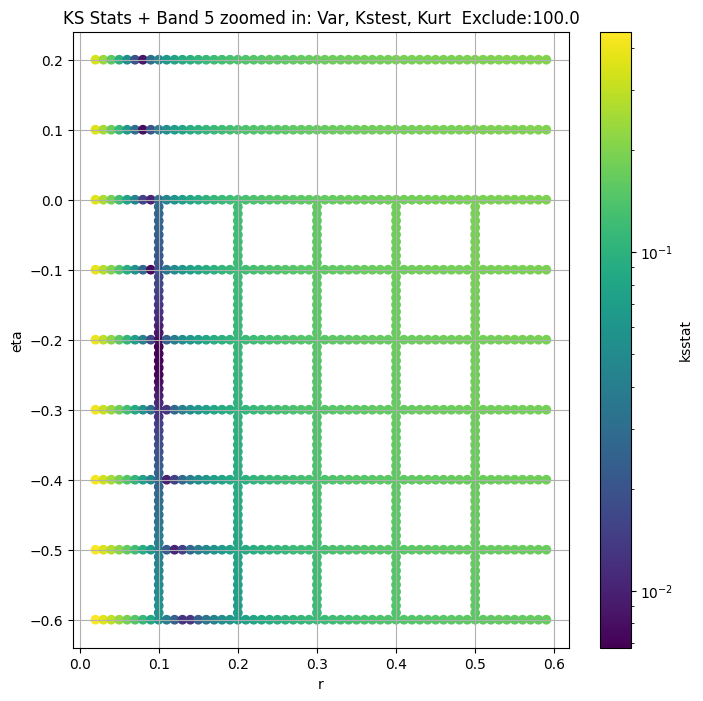

Band 6


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 100 = 300, ksstat: 0.008201480788596654, var: 5.314011573791504


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 75 = 275, ksstat: 0.007754043045606673, var: 5.508202075958252


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 50 = 250, ksstat: 0.007635283708239137, var: 5.717536449432373


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 25 = 225, ksstat: 0.007429148097580872, var: 5.944053649902344


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 0 = 200, ksstat: 0.0071224985922095155, var: 6.190550327301025


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + -25 = 175, ksstat: 0.0074631629112597575, var: 6.460646629333496


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + -50 = 150, ksstat: 0.007053280694619302, var: 6.7600226402282715


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + -75 = 125, ksstat: 0.007036052745545085, var: 7.09608268737793


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + -100 = 100, ksstat: 0.009208010542324896, var: 7.479269981384277
Number of samples: 100000, Without approximation : 100000.0


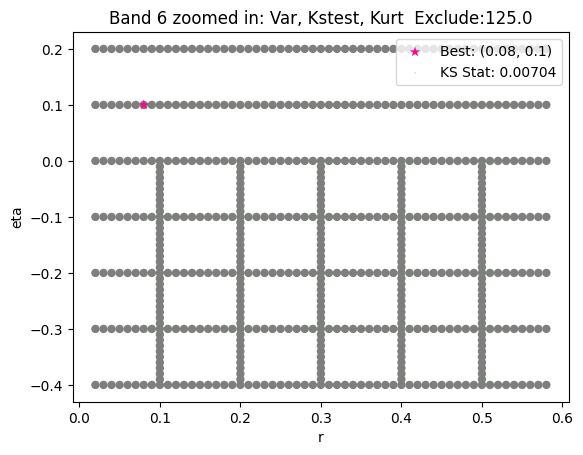

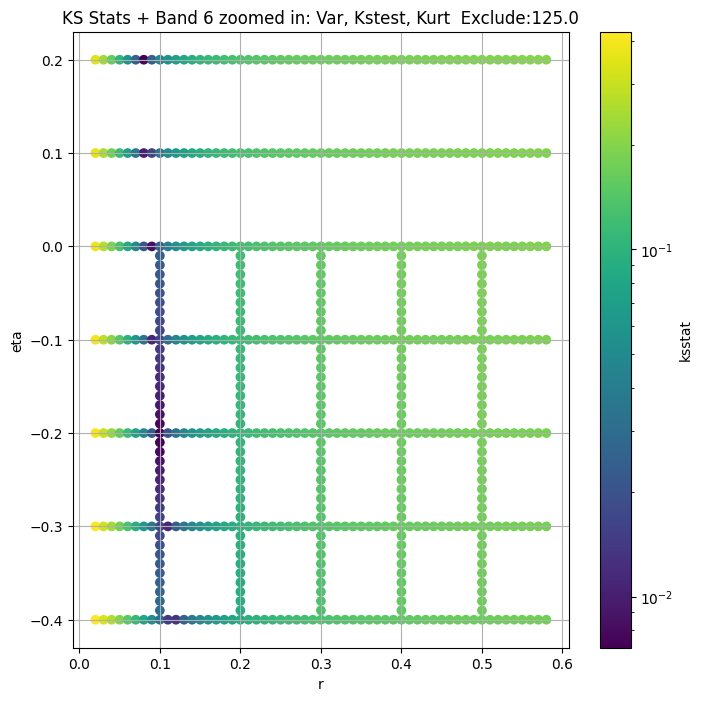

Band 7


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 100 = 300, ksstat: 0.007769709137741332, var: 2.0432369709014893


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 75 = 275, ksstat: 0.007816654421432291, var: 2.1171491146087646


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 50 = 250, ksstat: 0.00735611572600978, var: 2.197049379348755


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 25 = 225, ksstat: 0.007194156308358866, var: 2.283905267715454


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 0 = 200, ksstat: 0.0072127116192766925, var: 2.379031181335449


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + -25 = 175, ksstat: 0.00779992678121022, var: 2.4843027591705322


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + -50 = 150, ksstat: 0.008416854036902177, var: 2.601997137069702


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + -75 = 125, ksstat: 0.007770221791861431, var: 2.735538959503174


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + -100 = 100, ksstat: 0.00948968436032438, var: 2.8894426822662354
Number of samples: 100000, Without approximation : 100000.0


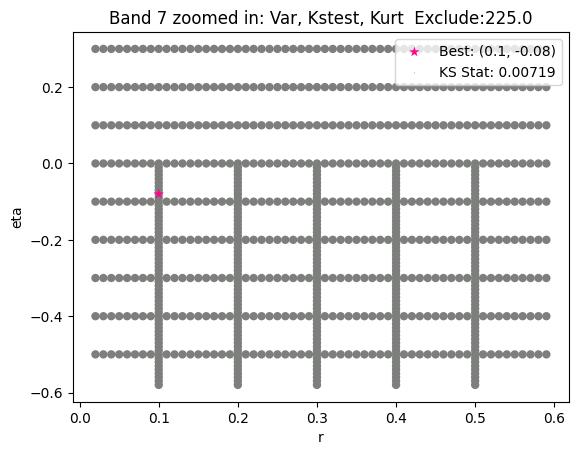

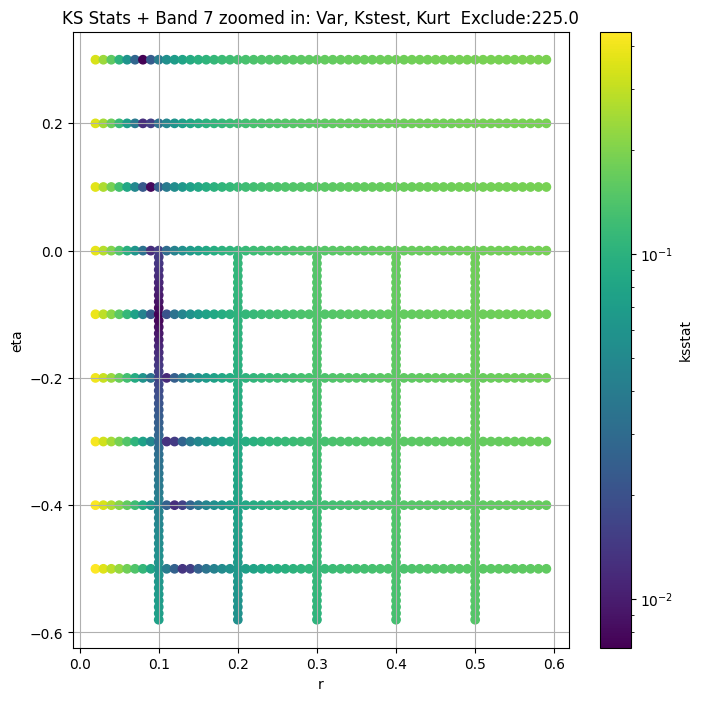

Band 8


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 100 = 450, ksstat: 0.009338516996625412, var: 0.3830191195011139


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 75 = 425, ksstat: 0.009245980393850084, var: 0.39424365758895874


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 50 = 400, ksstat: 0.009190526859856466, var: 0.4061141610145569


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 25 = 375, ksstat: 0.008575141971100375, var: 0.41869425773620605


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 0 = 350, ksstat: 0.008542269098581246, var: 0.43207085132598877


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + -25 = 325, ksstat: 0.009124222899132228, var: 0.44633033871650696


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + -50 = 300, ksstat: 0.008377899513370646, var: 0.46157601475715637


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + -75 = 275, ksstat: 0.010147381985811388, var: 0.47795340418815613


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + -100 = 250, ksstat: 0.010748565945225885, var: 0.495615154504776
Number of samples: 100000, Without approximation : 100000.0


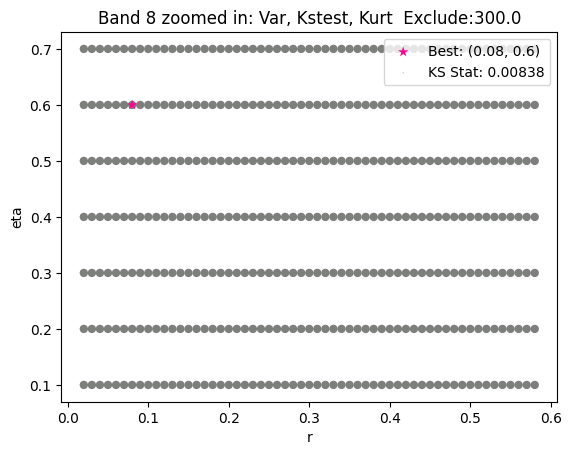

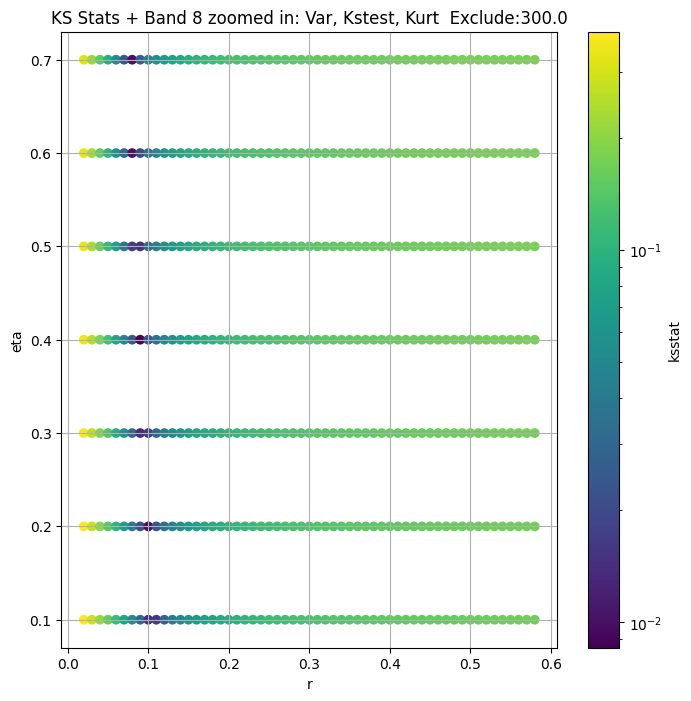

Band 9


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 100 = 600, ksstat: 0.009560534139309707, var: 0.07578899711370468


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 75 = 575, ksstat: 0.009476740797186294, var: 0.07813166826963425


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 50 = 550, ksstat: 0.00915541597815383, var: 0.08060455322265625


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 25 = 525, ksstat: 0.008958710581330652, var: 0.08321810513734818


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 0 = 500, ksstat: 0.010283257379130162, var: 0.08598314225673676


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + -25 = 475, ksstat: 0.011222900104971012, var: 0.08891364187002182


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + -50 = 450, ksstat: 0.010646231303897802, var: 0.09202595800161362


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + -75 = 425, ksstat: 0.011558744166230595, var: 0.09533966332674026


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + -100 = 400, ksstat: 0.011375605183496007, var: 0.09887557476758957
Number of samples: 100000, Without approximation : 100000.0


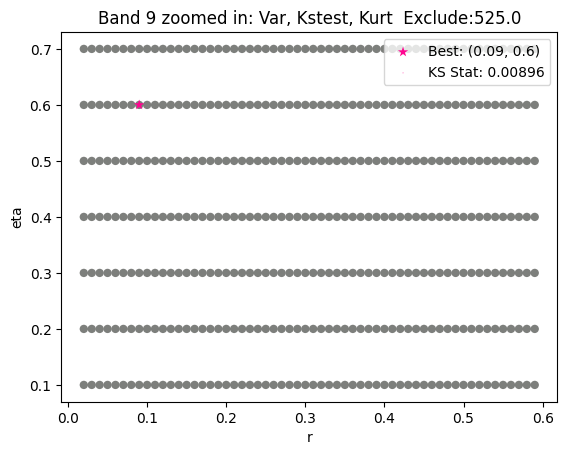

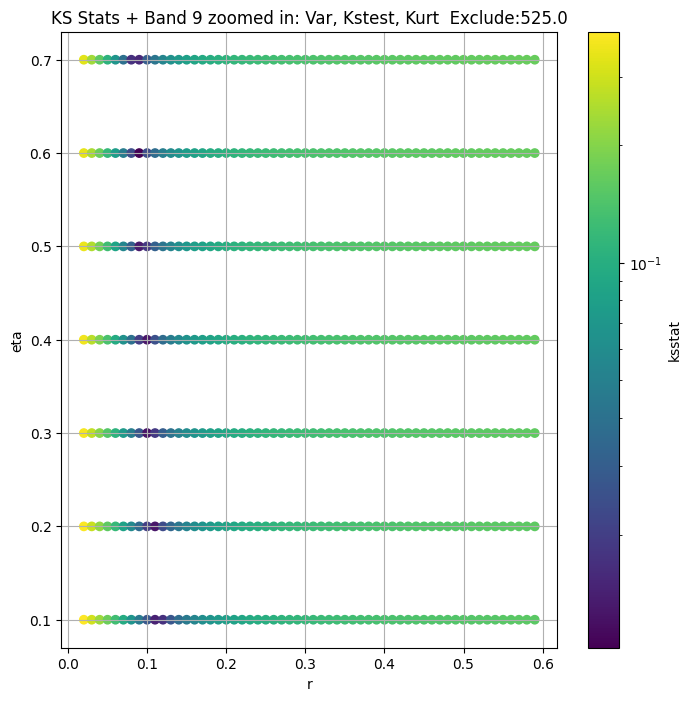

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,35.658936,30.577213,44.852737,53.40648,13.841323,225.49278,100000.0,0.003329,0.5,-1.0,1.454427e+01,100.0,32.253990,0.004293,0.001094,0.40,-0.95,5.578377e+00,25.0,1621827
3,24.671465,19.792730,36.469307,155.64215,23.847439,605.96010,100000.0,0.003971,0.3,-0.9,4.502093e-01,100.0,19.735750,0.004293,0.002209,0.30,-0.93,5.532430e-01,50.0,379687
4,22.381815,17.656353,31.781504,135.76886,34.770958,503.89240,100000.0,0.003575,0.1,-0.3,1.748667e-11,0.0,22.381815,0.004293,0.002640,0.10,-0.31,1.861914e-11,0.0,253125
5,12.393164,9.773663,16.739542,110.49154,39.733475,364.34058,100000.0,0.007555,0.1,-0.2,3.379833e-12,150.0,8.718793,0.004293,0.006189,0.09,-0.10,2.503629e-14,100.0,50000
6,11.326435,8.476332,19.273914,314.24930,43.632740,1044.14140,100000.0,0.007122,0.1,-0.2,2.638151e-12,200.0,7.096083,0.004293,0.007036,0.08,0.10,1.863000e-17,125.0,37500
7,4.390030,3.317100,6.534811,184.00717,46.270640,629.45245,100000.0,0.007221,0.1,-0.1,5.730414e-13,200.0,2.283905,0.004293,0.007194,0.10,-0.08,4.927219e-13,225.0,37500
8,0.972178,0.734719,1.474245,196.93523,43.928898,679.22850,100000.0,0.009904,0.1,0.2,2.241587e-14,350.0,0.461576,0.004293,0.008378,0.08,0.60,7.665771e-20,300.0,25000
9,0.286370,0.205979,0.508150,383.67706,56.914790,1211.13300,100000.0,0.012463,0.1,0.3,2.808659e-15,500.0,0.083218,0.004293,0.008959,0.09,0.60,6.383010e-18,525.0,23728


In [16]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [17]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

EngineError: Unknown exception

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex="kstest_stat.*")

In [ ]:
master_df.filter(regex="best.*")